## Basics of Spark Functioning

In the previous tutorial, we covered the technical architecture of Spark. Now, it's time to focus on the basics of its functioning.
In particular, we will explore the concepts of lazy evaluation, transformation, action, and caching.


In [20]:
import os

In [21]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         .getOrCreate()
        )

sc = spark.sparkContext

#### The Data: Sirene Opendata

We will reuse the exact codes from the previous tutorial and revisit the use of a schema.


In [22]:
import json
from pyspark.sql.types import StructType
import s3fs
import os

endpoint = "https://"+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})

with fs.open('s3://projet-spark-lab/diffusion/formation/schema/sirene/sirene.schema.json') as f:
    a = f.read()
    schema = StructType.fromJson(json.loads(a))

In [23]:
df = (spark.read
      .format("csv")
      .options(header='true', inferschema='false', delimiter=',')
      .schema(schema)
      .load("s3a://projet-spark-lab/diffusion/formation/data/sirene/sirene.csv")
     )

df.first()

Row(siren=325175, nic=16, siret=32517500016, dateFin='2007-12-31', dateDebut='2000-09-26', etatAdministratifEtablissement='A', changementEtatAdministratifEtablissement=False, enseigne1Etablissement=None, enseigne2Etablissement=None, enseigne3Etablissement=None, changementEnseigneEtablissement=False, denominationUsuelleEtablissement=None, changementDenominationUsuelleEtablissement=False, activitePrincipaleEtablissement=None, nomenclatureActivitePrincipaleEtablissement=None, changementActivitePrincipaleEtablissement='false', caractereEmployeurEtablissement='N', changementCaractereEmployeurEtablissement='false')

**WHAT????**

The line "df = spark.read.." executes instantly.. even though the file is 6 GB.
To understand this, you need to know its two objectives:
* Define the DataFrame
* Define/know the schema

Spark SQL, the module of Spark that works with structured data, needs the schema to optimize the execution plan of the Spark job.

Like last time, we can use a table view to perform SQL operations:


In [24]:
df.printSchema()

root
 |-- siren: integer (nullable = true)
 |-- nic: integer (nullable = true)
 |-- siret: long (nullable = true)
 |-- dateFin: string (nullable = true)
 |-- dateDebut: string (nullable = true)
 |-- etatAdministratifEtablissement: string (nullable = true)
 |-- changementEtatAdministratifEtablissement: boolean (nullable = true)
 |-- enseigne1Etablissement: string (nullable = true)
 |-- enseigne2Etablissement: string (nullable = true)
 |-- enseigne3Etablissement: string (nullable = true)
 |-- changementEnseigneEtablissement: boolean (nullable = true)
 |-- denominationUsuelleEtablissement: string (nullable = true)
 |-- changementDenominationUsuelleEtablissement: boolean (nullable = true)
 |-- activitePrincipaleEtablissement: string (nullable = true)
 |-- nomenclatureActivitePrincipaleEtablissement: string (nullable = true)
 |-- changementActivitePrincipaleEtablissement: string (nullable = true)
 |-- caractereEmployeurEtablissement: string (nullable = true)
 |-- changementCaractereEmployeu

#### An SQL Query

To do this, we register the DataFrame as the table "sirene" in a local catalog (which is not persistent after rebooting the Spark session).


In [10]:
df.createOrReplaceTempView("sirene")
sqlDF = spark.sql("SELECT * FROM sirene")

We seem to be executing a query on 60 million rows instantly. **Why?**

## LAZY EVALUATION, TRANSFORMATION, and ACTION

First, you need to know that in Spark, there are two types of operations: **transformations** and **actions**. Transformations in Spark are **lazy**, meaning that when you execute transformation functions in Spark, the framework does not execute them immediately but records the function called. All these operations build a DAG (Directed Acyclic Graph; we will discuss the graph in detail in a future tutorial dedicated to the anatomy of a Spark job). The entire set of operations in a Spark process is executed when an action function is invoked in the program (e.g., a count, a reduce, a write...).

It's important to recognize that in Spark, there are two realms:
* Spark's memory
* The rest of the world

As long as we define a DataFrame (without inferring the schema) and manipulate it by selecting columns or rows, Spark will not execute anything. Spark will wait until the last moment, which is when we want to output data (an action):
* to distributed storage (e.g., S3)
* to the Spark driver that runs the job (yes, the driver is also part of the rest of the world)

In fact, you can check your Spark UI; no job has been launched...

Let's proceed to the **first action**:


In [11]:
sqlDF.first()

Row(siren=325175, nic=16, siret=32517500016, dateFin='2007-12-31', dateDebut='2000-09-26', etatAdministratifEtablissement='A', changementEtatAdministratifEtablissement=False, enseigne1Etablissement=None, enseigne2Etablissement=None, enseigne3Etablissement=None, changementEnseigneEtablissement=False, denominationUsuelleEtablissement=None, changementDenominationUsuelleEtablissement=False, activitePrincipaleEtablissement=None, nomenclatureActivitePrincipaleEtablissement=None, changementActivitePrincipaleEtablissement='false', caractereEmployeurEtablissement='N', changementCaractereEmployeurEtablissement='false')

**Lazy, thus no unnecessary effort**

My file is 6 GB, I defined a transformation to select all rows, and then I defined an action to display only the first row of the DataFrame... clearly, given the speed of execution, Spark did not download the entire file from S3 but only the first few bytes.

**Lazy, so be careful**

In the following example, we will count the number of rows in the Sirene DataFrame three times in a row.


In [12]:
%%timeit -r3
sqlDF.count()

12.5 s ± 535 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


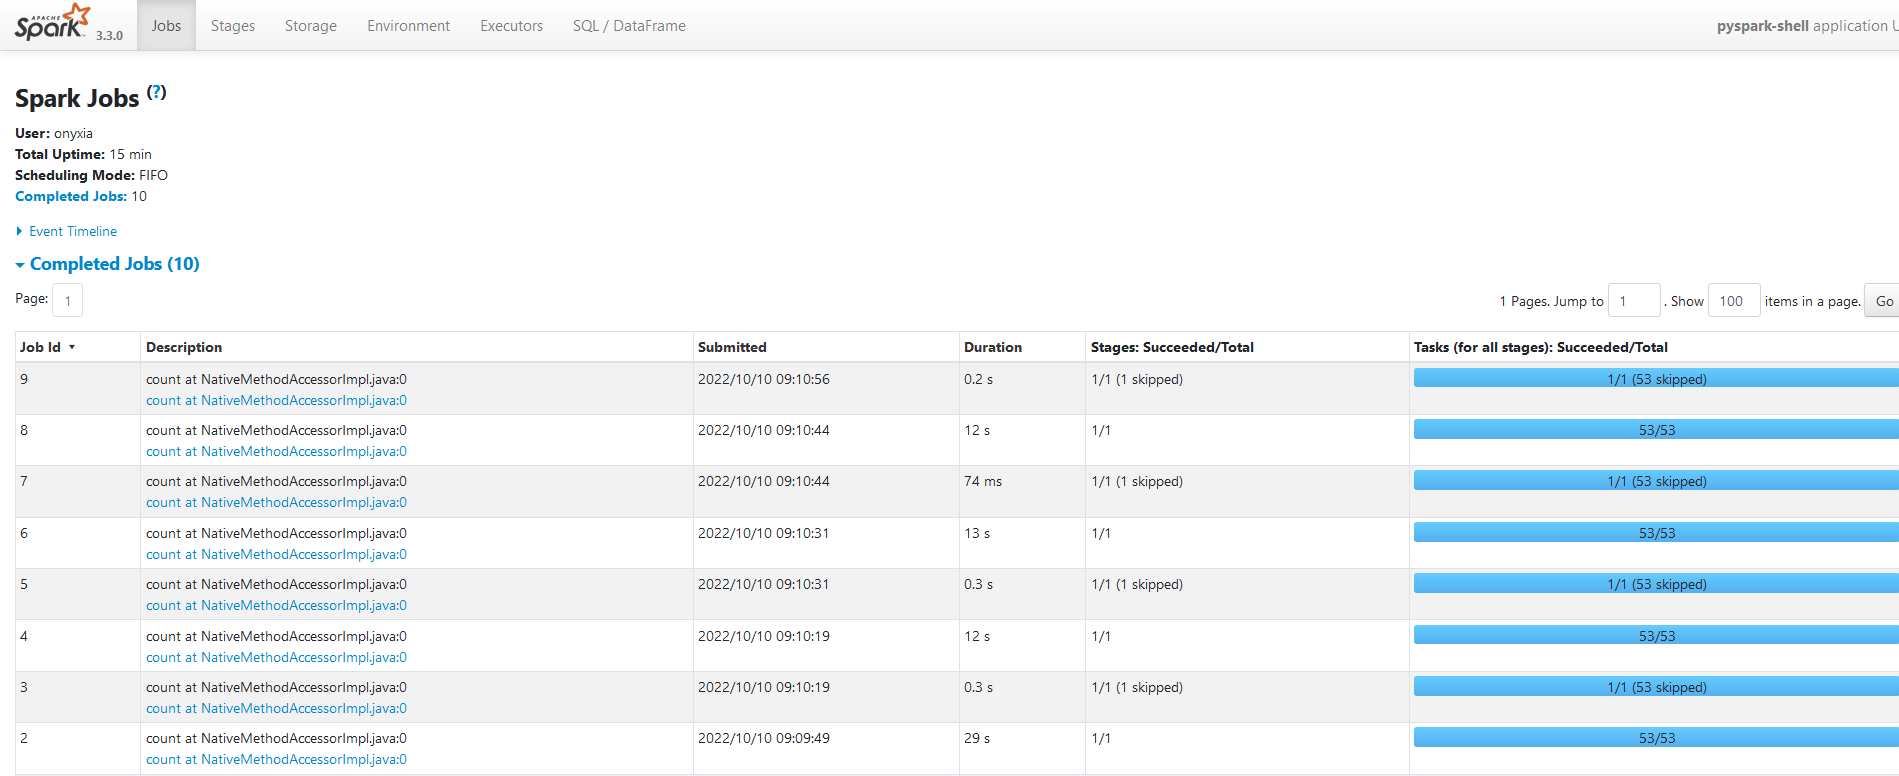

You can confirm that reading the 6 GB from storage takes 12 seconds each time we count the number of rows in the DataFrame. **There is no default caching**. It will be your responsibility to write efficient code by persisting your data in Spark upon the first use.


In [13]:
sqlDF.cache()

DataFrame[siren: int, nic: int, siret: bigint, dateFin: string, dateDebut: string, etatAdministratifEtablissement: string, changementEtatAdministratifEtablissement: boolean, enseigne1Etablissement: string, enseigne2Etablissement: string, enseigne3Etablissement: string, changementEnseigneEtablissement: boolean, denominationUsuelleEtablissement: string, changementDenominationUsuelleEtablissement: boolean, activitePrincipaleEtablissement: string, nomenclatureActivitePrincipaleEtablissement: string, changementActivitePrincipaleEtablissement: string, caractereEmployeurEtablissement: string, changementCaractereEmployeurEtablissement: string]

The cache instruction is also lazy... and the persistence (cache) will be performed at the next action executed on the DataFrame (such as a count).


In [14]:
%%timeit -r5
sqlDF.count()

284 ms ± 63.9 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


And you can verify on your Spark UI: **the first job took a long time because Spark had additional work to cache the data** (specifically, it had to change the data format as you can see we go from a CSV of over 6 GB to 2.9 GB), **but then all subsequent jobs executed from the cached data**, without ever consulting the file on S3 again. The storage tab provides information about the cached RDDs, the number of partitions, and whether the data could be stored in memory or on the executors' disks.


### A First Group-By to Conclude this Tutorial

We will group the cached data by APE code without using SQL syntax.


In [19]:
from pyspark.sql.functions import desc
sqlDF.groupBy("activitePrincipaleEtablissement").count().sort(desc("count")).head(10)

[Row(activitePrincipaleEtablissement=None, count=11036361),
 Row(activitePrincipaleEtablissement='68.20B', count=2822417),
 Row(activitePrincipaleEtablissement='70.2C', count=1724189),
 Row(activitePrincipaleEtablissement='70.22Z', count=961082),
 Row(activitePrincipaleEtablissement='68.20A', count=918291),
 Row(activitePrincipaleEtablissement='94.99Z', count=760587),
 Row(activitePrincipaleEtablissement='70.10Z', count=730658),
 Row(activitePrincipaleEtablissement='74.1J', count=727597),
 Row(activitePrincipaleEtablissement='85.1G', count=686920),
 Row(activitePrincipaleEtablissement='70.2A', count=650500)]

In [20]:
spark.stop()